In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [7]:
%run project.py

In [8]:
num_meters = 96
input_dim = num_meters
hidden_dim = 24
batch_dim = 1
output_dim = 96 * 4
num_layers = 24
learning_rate = 0.01
num_epochs = 500

In [9]:
ami = pd.read_csv('./data/ami-uniq.txt', sep='\t')
ami['datetime'] = pd.to_datetime(ami['datetime'], format='%Y-%m-%d %H:%M:%S')
#weather = pd.read_csv('./data/WeatherData_Zipcode_77088.csv')
#weather = weather.drop(columns=['LocalDateTime', 'TimeZone'])

In [10]:
#ami.loc[ami['id']==81].plot(y='kw', figsize=(30,6))

In [11]:
series_kw = ami.pivot(index='id', columns='datetime', values='kw')

In [12]:
#series_kw.count().unique()

In [13]:
t_0 = series_kw.loc[:,series_kw.count() > 82].columns[0]
t_f = series_kw.loc[:,series_kw.count() > 82].columns[-1]
kw_part = series_kw.loc[:,t_0:t_f].fillna(0)
kw_x_norm = (kw_part - kw_part.mean().mean()) / (kw_part.max().max() - kw_part.min().min())
kw_sum = kw_part.sum() / kw_part.count() * num_meters
kw_y_norm = (kw_sum - kw_sum.mean()) / (kw_sum.max() - kw_sum.min())

In [14]:
#kw_y_norm.plot(figsize=(100,5))

In [15]:
X_train = torch.tensor(kw_x_norm.transpose().values).float()
X_train = X_train.view([-1, 1, input_dim])
y_train = torch.tensor(kw_y_norm).float()
y_train = y_train.unfold(0, 96*4, 1)
#y_train.size()

In [16]:
model = AmiTest(input_dim, hidden_dim, batch_dim, output_dim, num_layers)
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
hist = np.zeros(num_epochs)

In [17]:
model.hidden = model.init_hidden()

In [ ]:
for t in range(num_epochs):
    model.hidden = model.init_hidden()
    y_pred = model(X_train)
    loss = loss_fn(y_pred[0:y_train.size(0),0], y_train)
    if t % 1 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch  0 MSE:  227448.203125


In [ ]:
t = 2060
plt.plot(y_pred[0:y_train.size(0),0][t].detach().numpy(), label="pred")
plt.plot(y_train[t].detach().numpy(), label="data")
plt.legend()
plt.show()

In [ ]:
t = 10384
plt.plot(y_pred[0:y_train.size(0),0][t].detach().numpy(), label="pred")
plt.plot(y_train[t].detach().numpy(), label="data")
plt.legend()
plt.show()

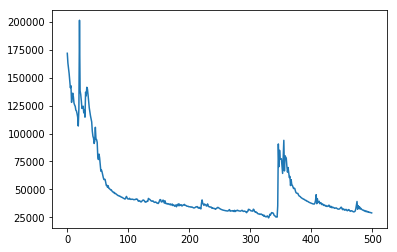

In [17]:
plt.plot(hist)